In [394]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as mp
import seaborn as sb
import math

import sklearn
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

import statsmodels
import arch
from statsmodels.tsa.api import adfuller, seasonal_decompose, SimpleExpSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from arch import arch_model
from prophet import Prophet

import tensorflow
import keras
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import Callback, EarlyStopping
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.optimizers import Adam

In [395]:
# Read the data
data = pd.read_csv('retail_store_inventory.csv')

# select a sample of the dataset for building model, later we can extend  it to the entire dataset
data = data[:10000]


data_description = """There are five stores: S001, S002, S003, S004, S005.
There are 20 products: P0001 to P0020.
There are 5 categories: Groceries, Furniture, Clothing, Electronics, Toys.
There are 4 regions: North, South, West, East.
There are 4 weather conditions: Rain, Snow, Sunny, Cloudy.
There are 4 seasons: Spring, Autumn, Summer, Winter.
There are 10,000 rows of data."""

print("Description about data:\n", data_description)
print()

# missing value information
print("Missing values:\n", data.isna().sum())
print()

# format date column 
data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d')
print('Date column has been changed to date data type')
print()

# drop product id as there are 20 product id for every store 
data = data[['Date', 'Store ID', 'Category', 'Region',
       'Inventory Level', 'Units Sold', 'Units Ordered', 'Demand Forecast',
       'Price', 'Discount', 'Weather Condition', 'Holiday/Promotion',
       'Competitor Pricing', 'Seasonality']]
print("columns we selected:", data.columns)
print()
data = pd.get_dummies(data, drop_first=True, dtype=int)
print("Converted categorical data into dummies")

#for sklearn models, we cant use date hence we will extract date, year, month and model them. 
#let's create a copy of our data into sklearn_data and proceed with Random forest, Gradient boosting model

sklearn_data = data.copy()

# Extract year, month, day from date as Random forest, Gradient boosting model will doesn’t understand time order
sklearn_data['year'] = sklearn_data['Date'].dt.year
sklearn_data['month'] = sklearn_data['Date'].dt.month
sklearn_data['day'] = sklearn_data['Date'].dt.day

# let's drop date column while building model using Random forest, Gradient boosting
sklearn_data = sklearn_data[['Inventory Level', 'Units Sold', 'Units Ordered',
       'Demand Forecast', 'Price', 'Discount', 'Holiday/Promotion',
       'Competitor Pricing', 'Store ID_S002', 'Store ID_S003', 'Store ID_S004',
       'Store ID_S005', 'Category_Electronics', 'Category_Furniture',
       'Category_Groceries', 'Category_Toys', 'Region_North', 'Region_South',
       'Region_West', 'Weather Condition_Rainy', 'Weather Condition_Snowy',
       'Weather Condition_Sunny', 'Seasonality_Spring', 'Seasonality_Summer',
       'Seasonality_Winter', 'year', 'month', 'day']]

Description about data:
 There are five stores: S001, S002, S003, S004, S005.
There are 20 products: P0001 to P0020.
There are 5 categories: Groceries, Furniture, Clothing, Electronics, Toys.
There are 4 regions: North, South, West, East.
There are 4 weather conditions: Rain, Snow, Sunny, Cloudy.
There are 4 seasons: Spring, Autumn, Summer, Winter.
There are 10,000 rows of data.

Missing values:
 Date                  0
Store ID              0
Product ID            0
Category              0
Region                0
Inventory Level       0
Units Sold            0
Units Ordered         0
Demand Forecast       0
Price                 0
Discount              0
Weather Condition     0
Holiday/Promotion     0
Competitor Pricing    0
Seasonality           0
dtype: int64

Date column has been changed to date data type

columns we selected: Index(['Date', 'Store ID', 'Category', 'Region', 'Inventory Level',
       'Units Sold', 'Units Ordered', 'Demand Forecast', 'Price', 'Discount',
       'Wea

### Sklearn models (Random Forest, Gradient boosting)

In [396]:
x = sklearn_data.drop(columns=['Demand Forecast'])
y = sklearn_data['Demand Forecast']
training_size = 7000
validation_size = 1000

# split the data into train, validation, test 

x_train = x.iloc[:training_size]
y_train = y.iloc[:training_size]

x_val = x.iloc[training_size:training_size+validation_size]
y_val = y.iloc[training_size:training_size+validation_size]

x_test = x.iloc[training_size+validation_size:]
y_test = y.iloc[training_size+validation_size:]

MAE for validation data is 7.7262308000000015 and test data is 7.628511249999998
RMSE for validation data is 9.052717282178872 and test data is 8.947642214458229


<Axes: >

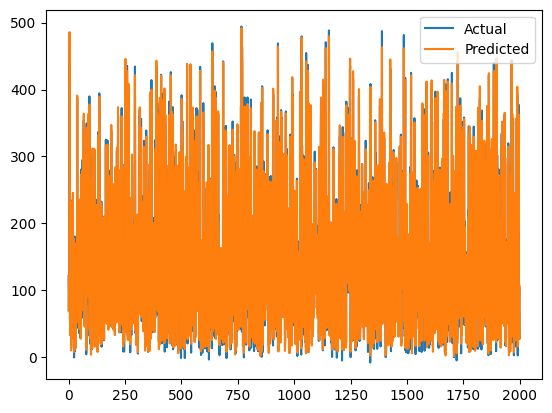

In [397]:
# Build the model
random_forest_model = RandomForestRegressor()
random_forest_model.fit(x_train, y_train)

# Predict the model on validation data 
random_forest_predictions_val = random_forest_model.predict(x_val)

# error metrics on validation data
random_forest_mae_val = mean_absolute_error(y_val, random_forest_predictions_val)
random_forest_rmse_val = math.sqrt(mean_squared_error(y_val, random_forest_predictions_val))

# predict the model on test data

random_forest_predictions_test = random_forest_model.predict(x_test)

#error metric on test data
random_forest_mae_test = mean_absolute_error(y_test, random_forest_predictions_test)
random_forest_rmse_test = math.sqrt(mean_squared_error(y_test, random_forest_predictions_test))

print(f'MAE for validation data is {random_forest_mae_val} and test data is {random_forest_mae_test}')
print(f'RMSE for validation data is {random_forest_rmse_val} and test data is {random_forest_rmse_test}')

# compare actual with predicted 
random_forest_predictions = pd.DataFrame(random_forest_predictions_test)
actual_vs_predicted = pd.concat([y_test.reset_index(drop=True), random_forest_predictions], axis=1)
actual_vs_predicted.columns = ['Actual', 'Predicted']
actual_vs_predicted.plot()

MAE for validation data is 7.581393694430303 and test data is 7.540225882664711
RMSE for validation data is 8.80741727259574 and test data is 8.73528115990767


<Axes: >

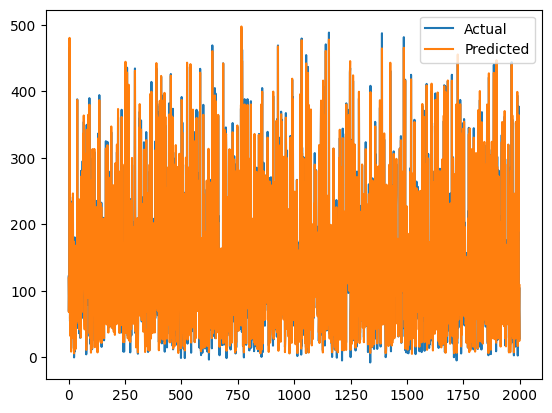

In [398]:
# Build the model
gradient_boost_model = GradientBoostingRegressor()
gradient_boost_model.fit(x_train, y_train)

# Predict the model on validation data 
gradient_boost_predictions_val = gradient_boost_model.predict(x_val)

# error metrics on validation data
gradient_boost_mae_val = mean_absolute_error(y_val, gradient_boost_predictions_val)
gradient_boost_rmse_val = math.sqrt(mean_squared_error(y_val, gradient_boost_predictions_val))

# predict the model on test data

gradient_boost_predictions_test = gradient_boost_model.predict(x_test)

#error metric on test data
gradient_boost_mae_test = mean_absolute_error(y_test, gradient_boost_predictions_test)
gradient_boost_rmse_test = math.sqrt(mean_squared_error(y_test, gradient_boost_predictions_test))

print(f'MAE for validation data is {gradient_boost_mae_val} and test data is {gradient_boost_mae_test}')
print(f'RMSE for validation data is {gradient_boost_rmse_val} and test data is {gradient_boost_rmse_test}')

# compare actual with predicted 
gradient_boost_predictions = pd.DataFrame(gradient_boost_predictions_test)
actual_vs_predicted = pd.concat([y_test.reset_index(drop=True), gradient_boost_predictions], axis=1)
actual_vs_predicted.columns = ['Actual', 'Predicted']
actual_vs_predicted.plot()

### Time Series Models 

In [399]:
# Data pre-processing for Time series models  (never remove date, set date as index)
time_series_data = data.copy()
time_series_data.set_index('Date', inplace=True)

In [400]:
#for TSA we define the train, test size. To avoid complexity, let's skip validation set
size = 8000

#split the data into train, test with all independent and dependent variables
train_data = time_series_data[:size]
test_data = time_series_data[size:]

# Define the exogeneous variables
train_data_exog = train_data[['Inventory Level', 'Units Sold', 'Units Ordered', 'Price', 'Discount', 'Holiday/Promotion', 
                              'Competitor Pricing', 'Store ID_S002', 'Store ID_S003', 'Store ID_S004', 'Store ID_S005', 
                              'Category_Electronics', 'Category_Furniture', 'Category_Groceries', 'Category_Toys', 
                              'Region_North', 'Region_South', 'Region_West', 'Weather Condition_Rainy', 'Weather Condition_Snowy', 
                              'Weather Condition_Sunny', 'Seasonality_Spring', 'Seasonality_Summer', 'Seasonality_Winter']]

test_data_exog = test_data[['Inventory Level', 'Units Sold', 'Units Ordered', 'Price', 'Discount', 'Holiday/Promotion', 
                            'Competitor Pricing', 'Store ID_S002', 'Store ID_S003', 'Store ID_S004', 'Store ID_S005', 
                            'Category_Electronics', 'Category_Furniture', 'Category_Groceries', 'Category_Toys', 
                            'Region_North', 'Region_South', 'Region_West', 'Weather Condition_Rainy', 'Weather Condition_Snowy', 
                            'Weather Condition_Sunny', 'Seasonality_Spring', 'Seasonality_Summer', 'Seasonality_Winter']]

In [401]:
# check if data is stationery
def stationery_check(data):
    result = adfuller(data)
    if result[1]<0.05:
        print("Data is stationery")
    else:
        print("Data is not stationery")

# check for 3 variables Demand forecast, Inventory levels, Price

stationery_check(train_data['Demand Forecast'])
stationery_check(train_data['Inventory Level'])
stationery_check(train_data['Price'])

Data is stationery
Data is stationery
Data is stationery


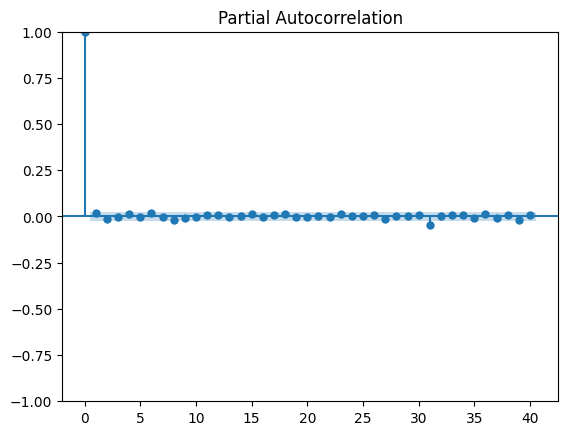

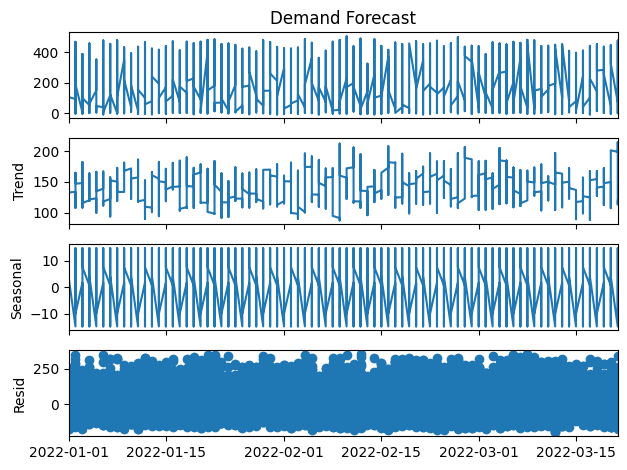

In [402]:
# check for correlation 
plot_pacf(train_data['Demand Forecast'])
mp.show()

# check for trend, seasonality, irregularity
sd = seasonal_decompose(train_data['Demand Forecast'], model='additive', period=30)
sd.plot()
mp.show()

d:\Data Science\Time Series Forecasting (TSA models & RNN LSTM)\TSA practicals\Forecasting Inventory & Demand\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Data Science\Time Series Forecasting (TSA models & RNN LSTM)\TSA practicals\Forecasting Inventory & Demand\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Data Science\Time Series Forecasting (TSA models & RNN LSTM)\TSA practicals\Forecasting Inventory & Demand\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  s

ARIMA model summary                                SARIMAX Results                                
Dep. Variable:        Demand Forecast   No. Observations:                 8000
Model:                 ARIMA(1, 0, 0)   Log Likelihood              -28632.755
Date:                Thu, 27 Mar 2025   AIC                          57319.510
Time:                        19:59:14   BIC                          57508.164
Sample:                             0   HQIC                         57384.083
                               - 8000                                         
Covariance Type:                  opg                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       4.5803      0.568      8.060      0.000       3.466       5.694
Inventory Level             0.0007      0.001      0.782      0.434     

d:\Data Science\Time Series Forecasting (TSA models & RNN LSTM)\TSA practicals\Forecasting Inventory & Demand\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
d:\Data Science\Time Series Forecasting (TSA models & RNN LSTM)\TSA practicals\Forecasting Inventory & Demand\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


<Axes: title={'center': 'Actual vs Predicted via Arima model'}, xlabel='Date'>

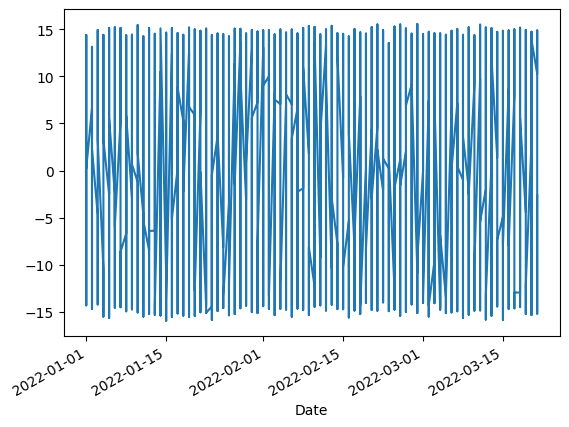

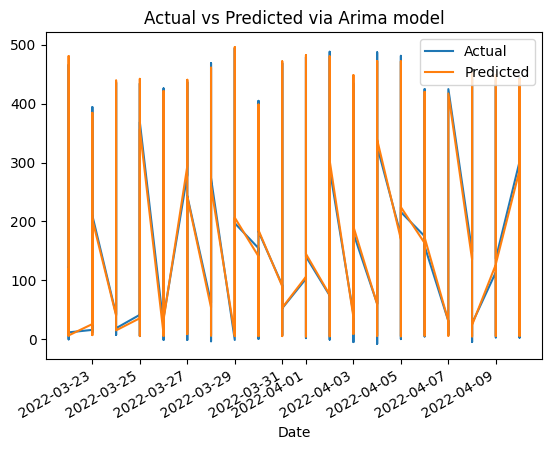

In [403]:
# ARIMA model

arima_model = ARIMA(train_data['Demand Forecast'], order=(1,0,0), exog=train_data_exog)
arima_model = arima_model.fit()
print("ARIMA model summary", arima_model.summary())
arima_model.resid.plot()

# define index range or start and end values on which predictions to be made
start_index = len(train_data)
end_index = len(train_data+test_data)-1

# predictions on test data
arima_predictions = arima_model.predict(start=start_index, end=end_index, exog=test_data_exog)

#error metric on test data
arima_mae = mean_absolute_error(test_data['Demand Forecast'], arima_predictions)
arima_rmse = math.sqrt(mean_squared_error(test_data['Demand Forecast'], arima_predictions))

print("ARIMA model error metrics:\n")
print(f'MAE: {arima_mae} and rmse: {arima_rmse}')

# check if test data and predictions have different index
print("Test Data Index:\n", test_data.index)
print("ARIMA Predictions Index:\n", arima_predictions.index)

# reindex 
arima_predictions_reshaped = pd.Series(arima_predictions.values, index=test_data.index)

# compare actual with predicted 
actual_vs_predicted_arima = pd.concat([test_data['Demand Forecast'], arima_predictions_reshaped], axis=1)
actual_vs_predicted_arima.columns = ['Actual', 'Predicted']
actual_vs_predicted_arima.plot(title='Actual vs Predicted via Arima model')

In [404]:
# Prophet method

prophet_model = Prophet()
prophet_model.add_regressor('Holiday/Promotion')  # Add external variables
prophet_model.add_regressor('Discount')
prophet_model.add_regressor('Competitor Pricing')

# create a copy of data only for prophet method before renaming the columns else the train data format gets corrupted
prophet_data = data.copy()
prophet_data = prophet_data.rename(columns = {'Date': 'ds', 'Demand Forecast':'y'})

#for prophet we define the train, test size and here date is not indexed.
prophet_training_size = 8000

#split the data into train, test with all independent and dependent variables
prophet_train_data = prophet_data[:prophet_training_size]
prophet_test_data = prophet_data[prophet_training_size:]
prophet_model.fit(prophet_train_data)

#predict on test data 
prophet_predictions = prophet_model.predict(prophet_test_data)

#extract relevant columns as the model creates numerous columns
prophet_predictions = prophet_predictions[['ds', 'yhat']]

#yhat is our predictions
# prophet_predictions = prophet_predictions.rename(columns={'ds':'date', 'yhat':'predicted'})

19:59:17 - cmdstanpy - INFO - Chain [1] start processing
19:59:17 - cmdstanpy - INFO - Chain [1] done processing


Prophet Test Data Index:
 RangeIndex(start=8000, stop=10000, step=1)
Prophet Predictions Index:
 RangeIndex(start=0, stop=2000, step=1)

After reshaping or reindexing...
Prophet Test Data Index:
 RangeIndex(start=0, stop=2000, step=1)
Prophet Predictions Index:
 RangeIndex(start=0, stop=2000, step=1)

Actual vs Predicted via Prophet method:
            y         ds        yhat
0     121.45 2022-03-22  140.732016
1      68.88 2022-03-22  142.057056
2     103.75 2022-03-22  142.148965
3     127.69 2022-03-22  139.814613
4     466.33 2022-03-22  139.861052
...      ...        ...         ...
1995  377.25 2022-04-10  139.478834
1996   78.36 2022-04-10  139.002240
1997   59.26 2022-04-10  141.655655
1998   27.11 2022-04-10  139.446991
1999  103.49 2022-04-10  138.072237

[2000 rows x 3 columns]
Actual vs predicted column names: Index(['y', 'ds', 'yhat'], dtype='object')


<Axes: title={'center': 'Actual vs Predicted via Prophet model'}, xlabel='Date'>

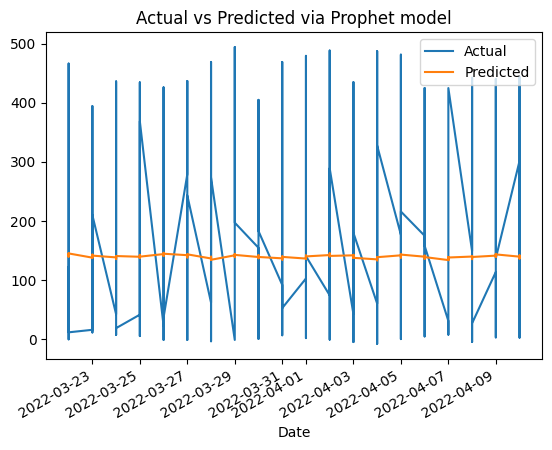

In [405]:
# check if test data and predictions have different index
print("Prophet Test Data Index:\n", prophet_test_data.index)
print("Prophet Predictions Index:\n", prophet_predictions.index)
print()

# Reset index before merging
prophet_test_data_reindexed = prophet_test_data.reset_index(drop=True)
prophet_predictions_reindexed = prophet_predictions.reset_index(drop=True)

print("After reshaping or reindexing...")

# recheck on index 
print("Prophet Test Data Index:\n", prophet_test_data_reindexed.index)
print("Prophet Predictions Index:\n", prophet_predictions_reindexed.index)
print()

# compare actual with predicted 
actual_vs_predicted_prophet = pd.concat([prophet_test_data_reindexed[['y']], 
                                         prophet_predictions_reindexed[['ds', 'yhat']]], 
                                         axis=1)
print("Actual vs Predicted via Prophet method:\n", actual_vs_predicted_prophet)
print("Actual vs predicted column names:", actual_vs_predicted_prophet.columns)
actual_vs_predicted_prophet.columns = ['Actual', 'Date', 'Predicted']
actual_vs_predicted_prophet
actual_vs_predicted_prophet.set_index('Date', inplace=True)
actual_vs_predicted_prophet.plot(title='Actual vs Predicted via Prophet model')